# Reverse time migration (RTM) of the 2D acoustic Marmousi 2 model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
import plotting

MARMOUSI_PATH = 'Marmousi2_elastic.npz'

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Load and plot marmousi 

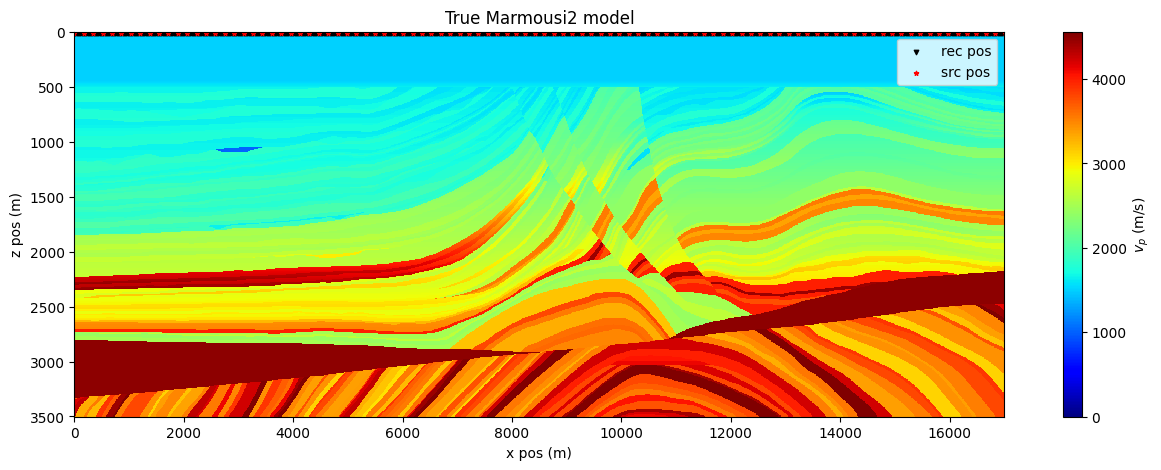

In [2]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 100
x_src = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_src)
z_src = 10.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

plotting.plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation

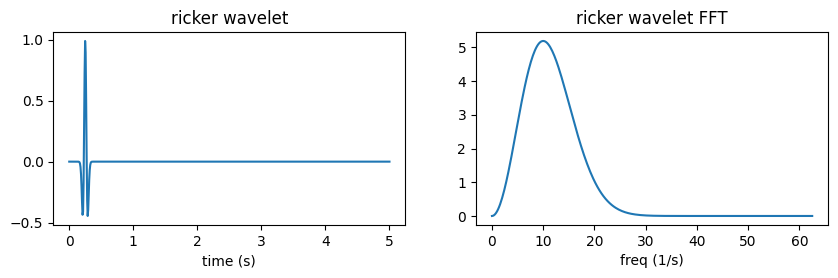

In [3]:
# make a Ricker wavelet
n_t = 626
d_t = 0.008
dom_freq = 10.0
delay= 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plotting.plot_wavelet(ricker,d_t,title='ricker wavelet')

In [4]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(50, 50),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3])

## Make observed data

CPU times: user 2min 28s, sys: 1min 9s, total: 3min 37s
Wall time: 39.9 s


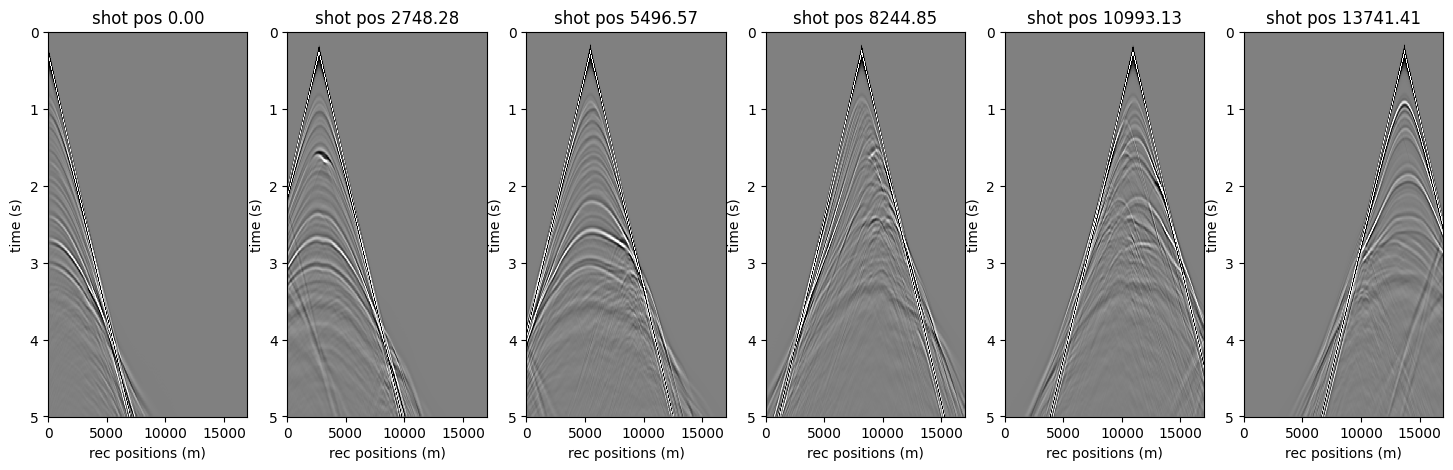

In [5]:
%%time
data_obs = acoustic_2d.forward(true_model)

plotting.plot_data(data_obs,
          d_t,
          src_locations=x_src,
          rec_locations=x_rec)

## Make migration velocity model

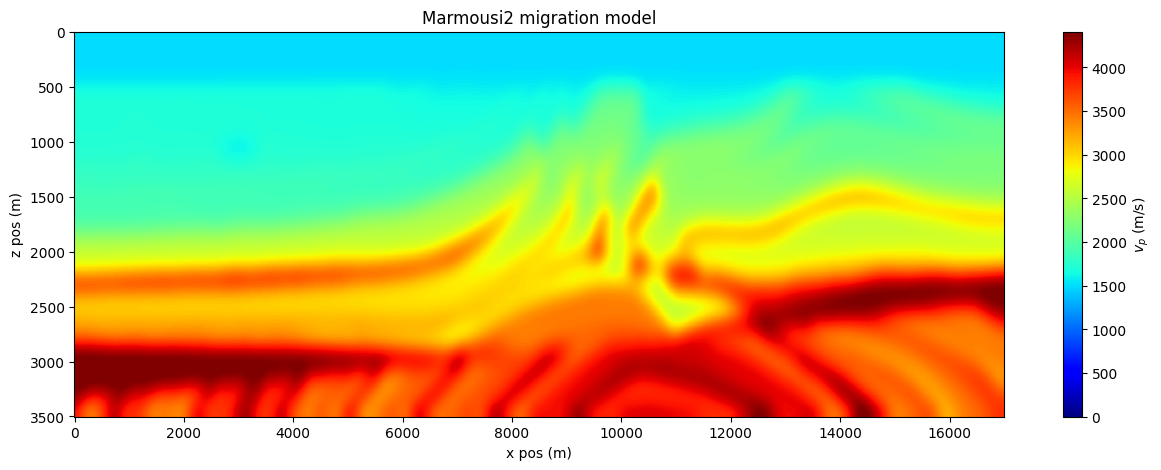

In [6]:
mig_model = ndimage.gaussian_filter(true_model,sigma=(20,20))

plotting.plot_model(mig_model,
           title='Marmousi2 migration model', 
           cbar=True)

## Run reverse time migration (RTM)

CPU times: user 13min 41s, sys: 3min 5s, total: 16min 47s
Wall time: 1min 56s


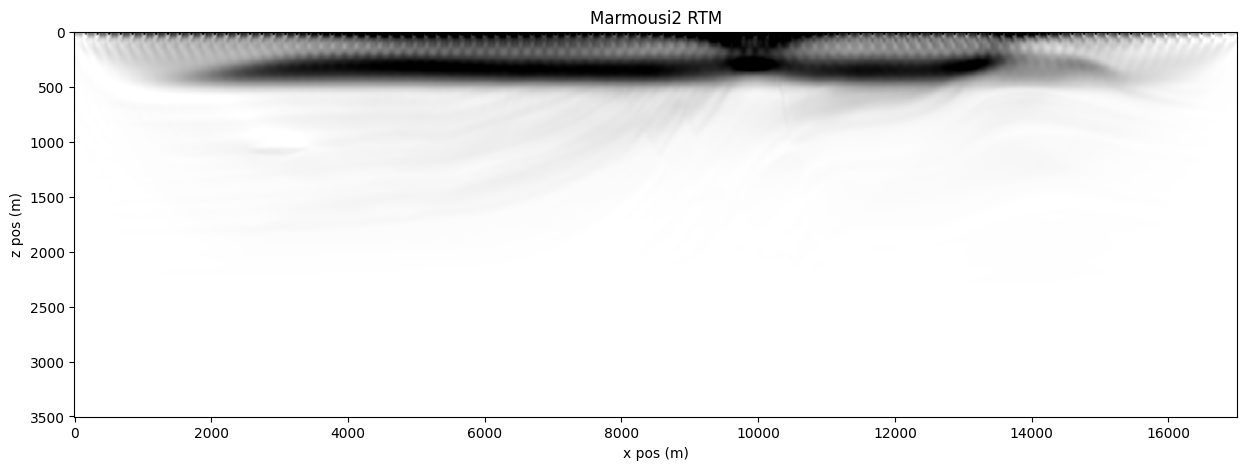

In [10]:
%%time
img = acoustic_2d.jacobian_adjoint(data_obs,mig_model)

clip = np.percentile(abs(img),99)
plotting.plot_model(img,
           title='Marmousi2 RTM', 
           cmap='gray',
           vlims=[-clip,clip])

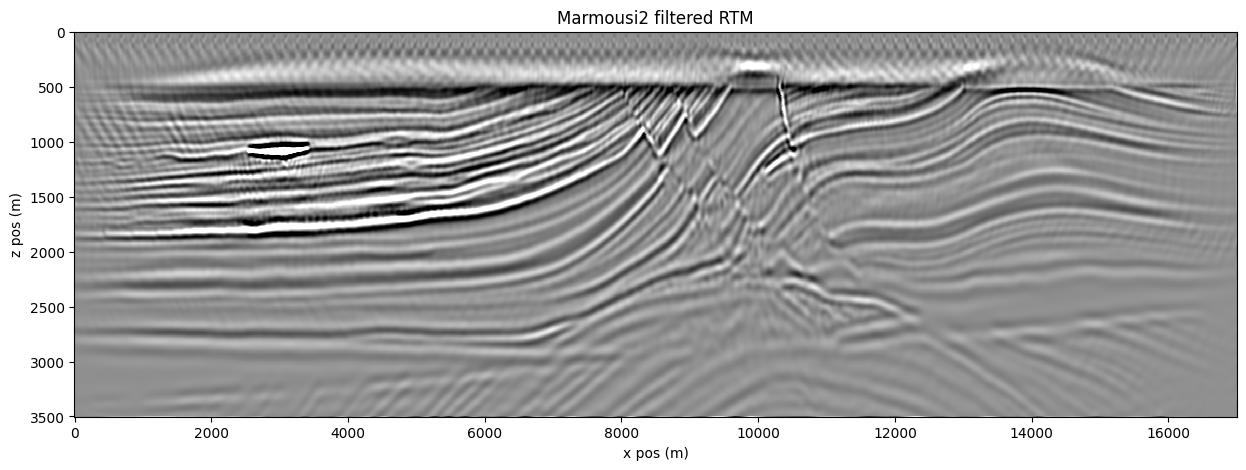

In [11]:
# apply laplace filter and apply tpow
img_filter = np.arange(img.shape[-1])**2 * ndimage.laplace(img)

clip = np.percentile(abs(img_filter),99)
plotting.plot_model(img_filter,
           title='Marmousi2 filtered RTM', 
           cmap='gray',
           vlims=[-clip,clip])